# Scale Out Performance Test

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from datetime import time
%matplotlib inline

In [2]:
#!pip install xlrd openpyxl

### load

In [3]:
df = pd.read_excel('scaleout.xlsx', sheet_name=u'sheet', index_col=None)

### schema

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 12 columns):
#nodes          1620 non-null int64
#executors      1620 non-null int64
#no             1620 non-null int64
arrow_job_id    1620 non-null object
arrow_name      1620 non-null object
pipeline        1620 non-null object
stage           6 non-null object
status          1620 non-null object
start_time      1620 non-null datetime64[ns]
elapsed_time    1620 non-null object
end_time        1619 non-null datetime64[ns]
except          2 non-null object
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 151.9+ KB


### head

In [5]:
df.head()

,#nodes,#executors,#no,arrow_job_id,arrow_name,pipeline,stage,status,start_time,elapsed_time,end_time,except
0,1,1,1,20190522175906-88803,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:06,04:05:22,2019-05-22 22:04:28,NaN
1,1,1,1,20190522175905-23082,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:05,04:03:18,2019-05-22 22:02:23,NaN
2,1,1,1,20190522175905-05312,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:05,04:05:36,2019-05-22 22:04:41,NaN
3,1,1,1,20190522175904-22548,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:04,04:01:22,2019-05-22 22:00:26,NaN
4,1,1,1,20190522175904-10087,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:04,04:06:08,2019-05-22 22:05:12,NaN


### preprocess

In [6]:
df = df[df['status'] == 'DONE']
df = df[df['except'].isna()]

In [7]:
df['elapsed_time'] = df['elapsed_time'].map(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
df.head()

,#nodes,#executors,#no,arrow_job_id,arrow_name,pipeline,stage,status,start_time,elapsed_time,end_time,except
0,1,1,1,20190522175906-88803,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:06,14722,2019-05-22 22:04:28,NaN
1,1,1,1,20190522175905-23082,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:05,14598,2019-05-22 22:02:23,NaN
2,1,1,1,20190522175905-05312,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:05,14736,2019-05-22 22:04:41,NaN
3,1,1,1,20190522175904-22548,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:04,14482,2019-05-22 22:00:26,NaN
4,1,1,1,20190522175904-10087,app,app-task1->app-task2->app-task3->app-task4->ap...,NaN,DONE,2019-05-22 17:59:04,14768,2019-05-22 22:05:12,NaN


### box plot

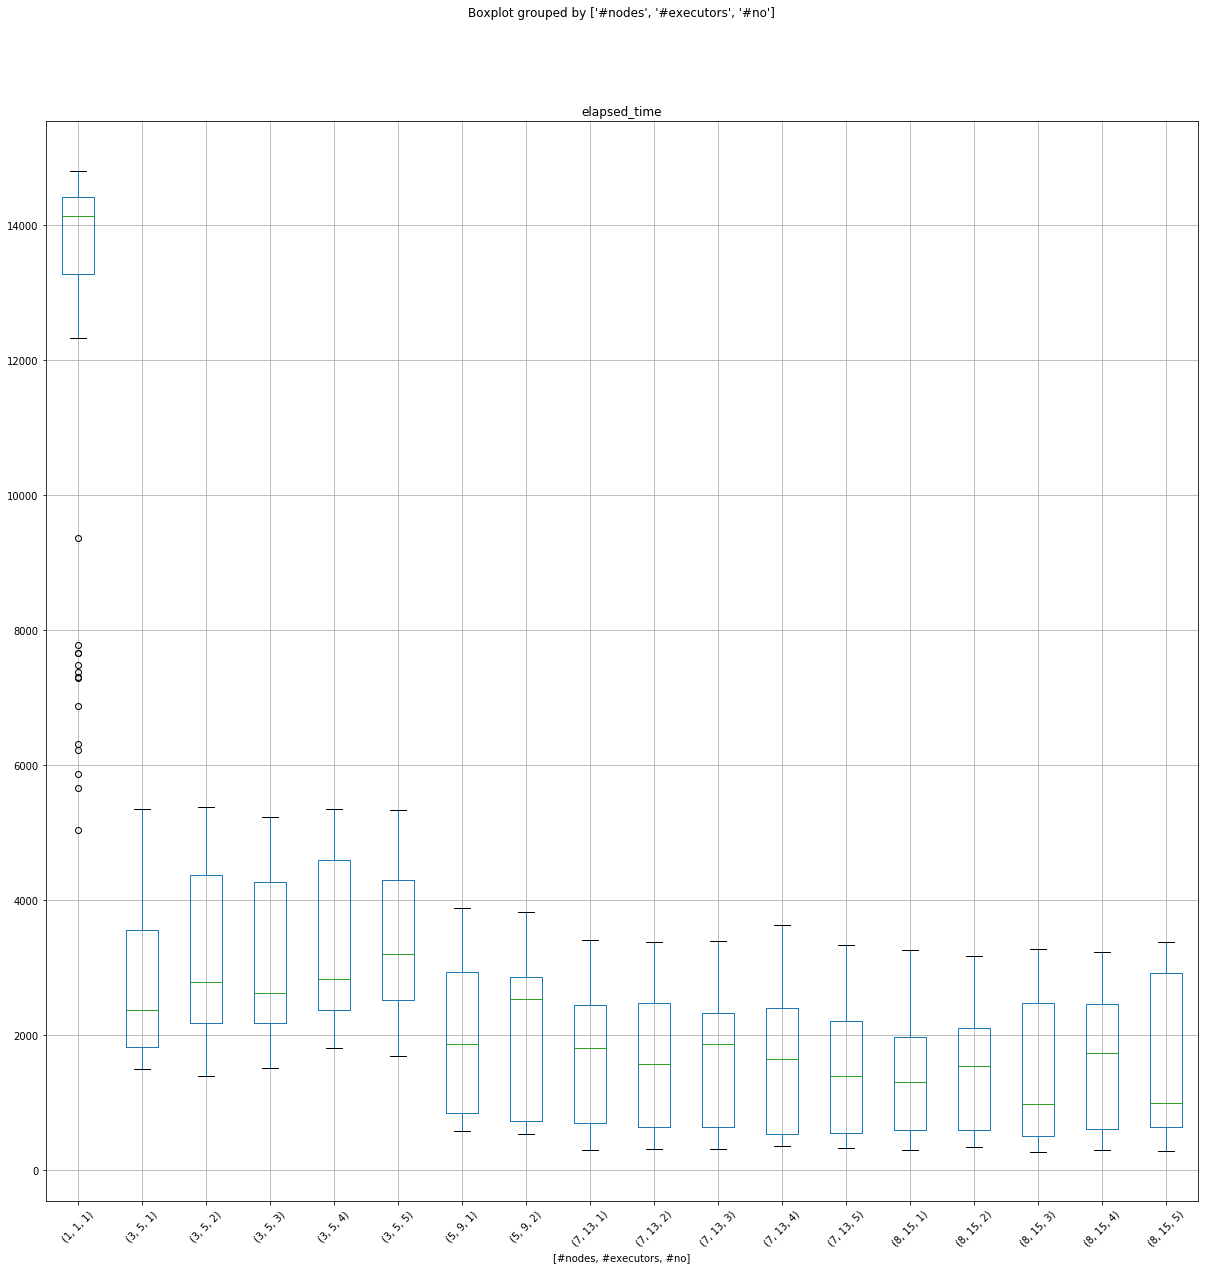

In [8]:
df.boxplot(by=['#nodes', '#executors', '#no'], column='elapsed_time', figsize=(20,20), rot=45, whis=1.3)

### agg by #nodes, #executors, #no

In [9]:
group = df.groupby(['#nodes', '#executors', '#no'])
df2 = pd.DataFrame({'start_time': group['start_time'].apply(np.min), 'end_time': group['end_time'].apply(np.max)}, columns=['start_time', 'end_time'])
df2['elapsed_time'] = df2['end_time'] - df2['start_time']
df2['elapsed_time'] = df2['elapsed_time'].map(str)
df2['elapsed_time'] = df2['elapsed_time'].map(lambda s: s.replace('0 days ', ''))

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 18 entries, (1, 1, 1) to (8, 15, 5)
Data columns (total 3 columns):
start_time      18 non-null datetime64[ns]
end_time        18 non-null datetime64[ns]
elapsed_time    18 non-null object
dtypes: datetime64[ns](2), object(1)
memory usage: 736.0+ bytes


In [11]:
df2

start_time            end_time elapsed_time
#nodes #executors #no                                                     
1      1          1   2019-05-22 17:58:27 2019-05-22 22:05:38     04:07:11
3      5          1   2019-05-23 12:04:16 2019-05-23 13:33:40     01:29:24
                  2   2019-05-23 14:12:24 2019-05-23 15:42:05     01:29:41
                  3   2019-05-23 15:52:05 2019-05-23 17:19:30     01:27:25
                  4   2019-05-23 17:37:00 2019-05-23 19:06:17     01:29:17
                  5   2019-05-24 08:56:51 2019-05-24 10:25:41     01:28:50
5      9          1   2019-05-24 12:10:14 2019-05-24 13:15:01     01:04:47
                  2   2019-05-24 14:34:17 2019-05-24 15:38:04     01:03:47
7      13         1   2019-05-27 16:08:37 2019-05-27 17:05:34     00:56:57
                  2   2019-05-27 20:38:11 2019-05-27 21:34:32     00:56:21
                  3   2019-05-27 22:08:35 2019-05-27 23:05:17     00:56:42
                  4   2019-05-28 01:03:18 2019-05-28 02:03:57     01:00:39
                  5   2019-05-28 06:22:58 2019-05-28 07:18:40     00:55:42
8      15         1   2019-05-29 03:53:22 2019-05-29 04:47:54     00:54:32
                  2   2019-05-29 08:03:32 2019-05-29 08:56:35     00:53:03
                  3   2019-05-29 09:11:54 2019-05-29 10:06:38     00:54:44
                  4   2019-05-29 17:13:49 2019-05-29 18:07:49     00:54:00
                  5   2019-05-29 21:13:33 2019-05-29 22:10:03     00:56:30

In [12]:
#with pd.ExcelWriter('scaleout.xlsx', mode='a') as writer:
#    df2.to_excel(writer, sheet_name='test')

### agg by #nodes, #executors

In [13]:
def convert(x):
    try:
        t = datetime.strptime(x, '%H:%M:%S')
        d = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    except:
        return None
    return d.seconds
df2['elapsed_time'] = df2['elapsed_time'].map(convert)

group = df2.groupby(['#nodes', '#executors'])
df3 = pd.DataFrame({'elapsed_time': group['elapsed_time'].apply(np.average)}, columns=['elapsed_time'])

In [14]:
df3

,,elapsed_time
#nodes,#executors,
1,1,14831.0
3,5,5335.4
5,9,3857.0
7,13,3436.2
8,15,3273.8


### line plot (elapsed_time)

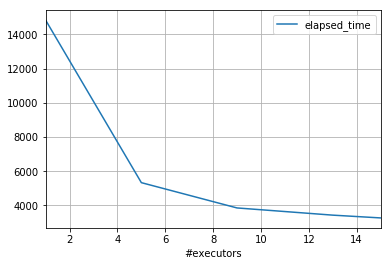

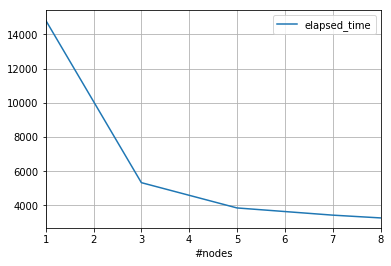

In [15]:
df3.reset_index(level='#nodes', drop=True).plot(grid=True)
df3.reset_index(level='#executors', drop=True).plot(grid=True)

### line plot (throughput per hour)

In [16]:
df4 = 90 / ( df3 / 3600.0 )
df4 = df4.rename(columns={"elapsed_time": "throughput per hour"})

In [17]:
df4

,,throughput per hour
#nodes,#executors,
1,1,21.846133
3,5,60.726468
5,9,84.003111
7,13,94.290204
8,15,98.967561


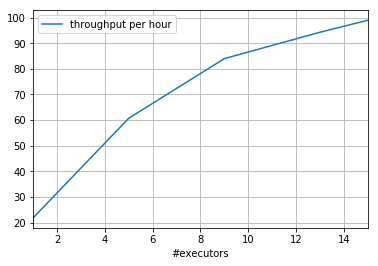

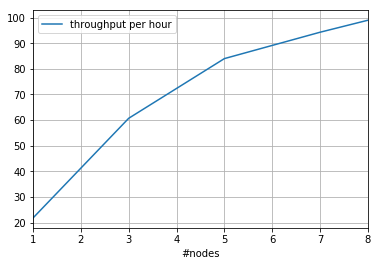

In [18]:
df4.reset_index(level='#nodes', drop=True).plot(grid=True)
df4.reset_index(level='#executors', drop=True).plot(grid=True)